In [1]:
import time
import math
import hdbscan
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from classix import CLASSIX, loadData
from quickshift.QuickshiftPP import * # download from https://github.com/google/quickshift

In [2]:
data = loadData('vdu_signals') # load the data
print(data.shape) # (2028780, 2)

(2028780, 2)


In [3]:
# This block of code is provided by Kamil Oster
final_len = 0.05 * data.shape[0]
outliers_position = np.where(data[:,0] > 7.5)[0]
no_outliers_position = np.delete(np.arange(0, len(data[:,0])), outliers_position, axis=0)

outlier_len = len(outliers_position)
data_no_outliers_length = int(final_len - outlier_len)

data_outliers = data[outliers_position, :]
data_no_outliers = np.delete(data, outliers_position, axis=0)

random_integers = np.arange(0, len(no_outliers_position))
np.random.shuffle(random_integers)

data_no_outliers_out = data_no_outliers[random_integers[data_no_outliers_length:],:]
data_no_outliers =  data_no_outliers[random_integers[:data_no_outliers_length],:]

X = np.concatenate((data_no_outliers, data_outliers))
print(X.shape)

(101439, 2)


In [4]:
sample_size = 10 # each algorithm's running repeats for 10 times

sum_time = 0
timing = []

Average consume time:  10.794459247589112


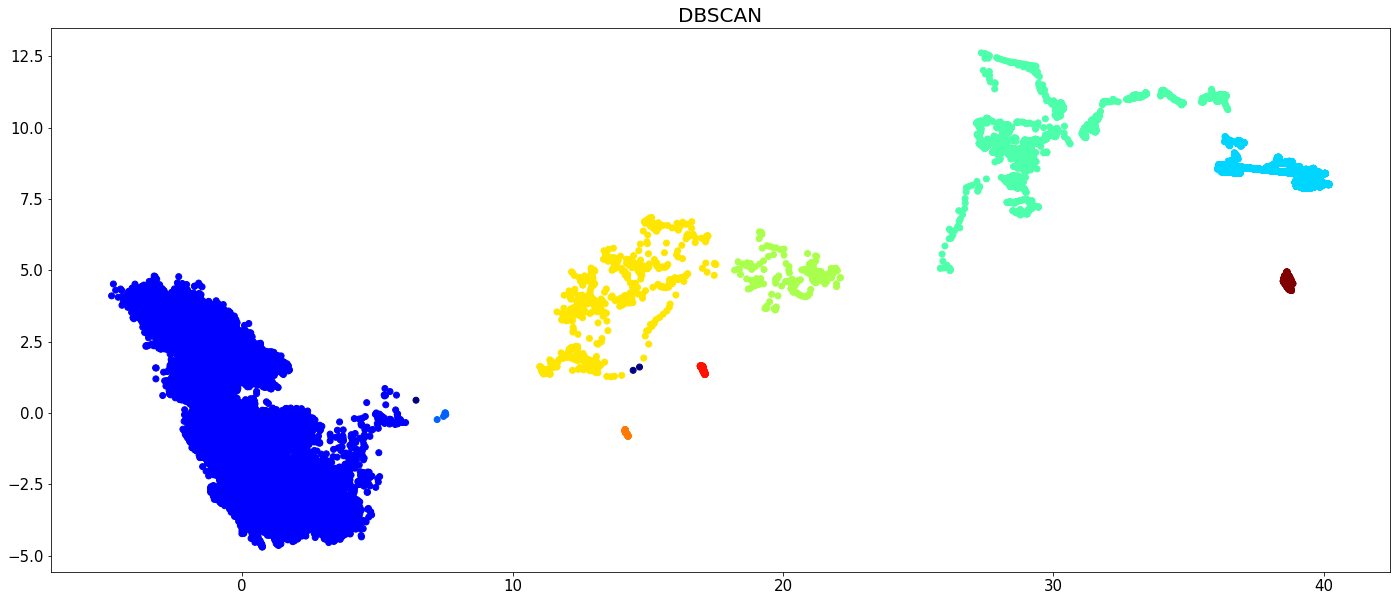

In [5]:
for i in range(sample_size):
    st = time.time()
    dbscan = DBSCAN(eps=0.7, min_samples=6)
    dbscan.fit(X)
    et = time.time()
    sum_time = sum_time + et - st

timing.append(sum_time/sample_size)
print("Average consume time: ", sum_time/sample_size)
plt.figure(figsize=(24,10))
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_, cmap='jet')
plt.tick_params(axis='both',  labelsize=15)
plt.title('DBSCAN',  fontsize=20)
plt.show()


Average consume time:  18.990439295768738


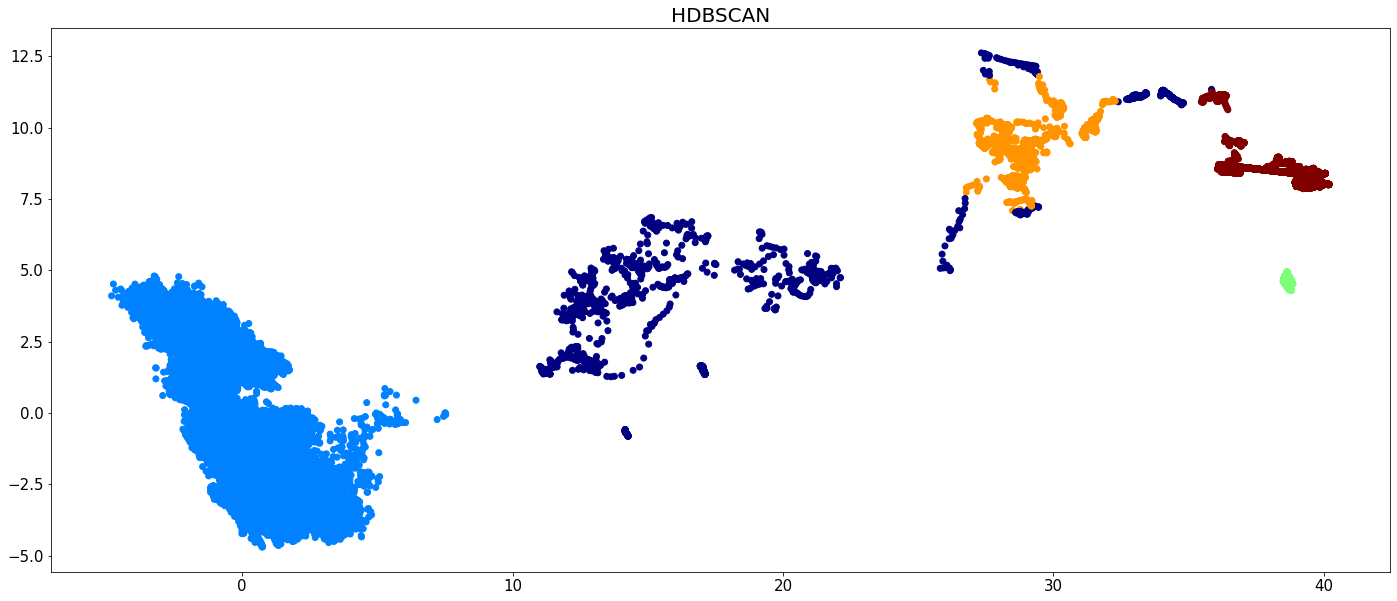

In [6]:
sum_time = 0
for i in range(sample_size):
    st = time.time()
    _hdbscan = hdbscan.HDBSCAN(min_cluster_size=1100, core_dist_n_jobs=1)
    hdbscan_labels = _hdbscan.fit_predict(X)
    et = time.time()
    sum_time = sum_time + et - st

timing.append(sum_time/sample_size)
print("Average consume time: ", sum_time/sample_size)
plt.figure(figsize=(24,10))
plt.scatter(X[:,0], X[:,1], c=hdbscan_labels, cmap='jet')
plt.tick_params(axis='both',  labelsize=15)
plt.title('HDBSCAN',  fontsize=20)
plt.show()

Average consume time:  69.32177667617798


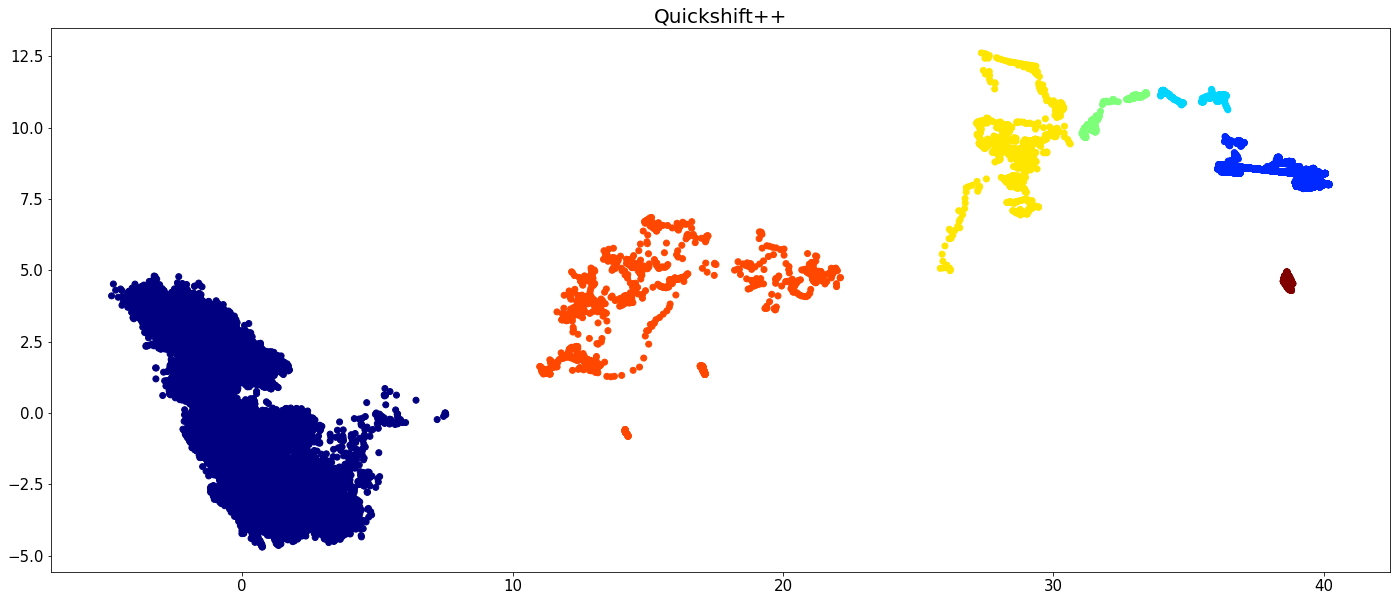

In [7]:
sum_time = 0
for i in range(sample_size):
    st = time.time()
    quicks = QuickshiftPP(k=450, beta=0.75)
    quicks.fit(X.copy(order='C'))
    quicks_labels = quicks.memberships
    et = time.time()
    sum_time = sum_time + et - st
timing.append(sum_time/sample_size)
print("Average consume time: ", sum_time/sample_size)
plt.figure(figsize=(24,10))
plt.scatter(X[:,0], X[:,1], c=quicks_labels, cmap='jet')
plt.tick_params(axis='both',  labelsize=15)
plt.title('Quickshift++',  fontsize=20)
plt.show()

Average consume time:  1.4928614377975464


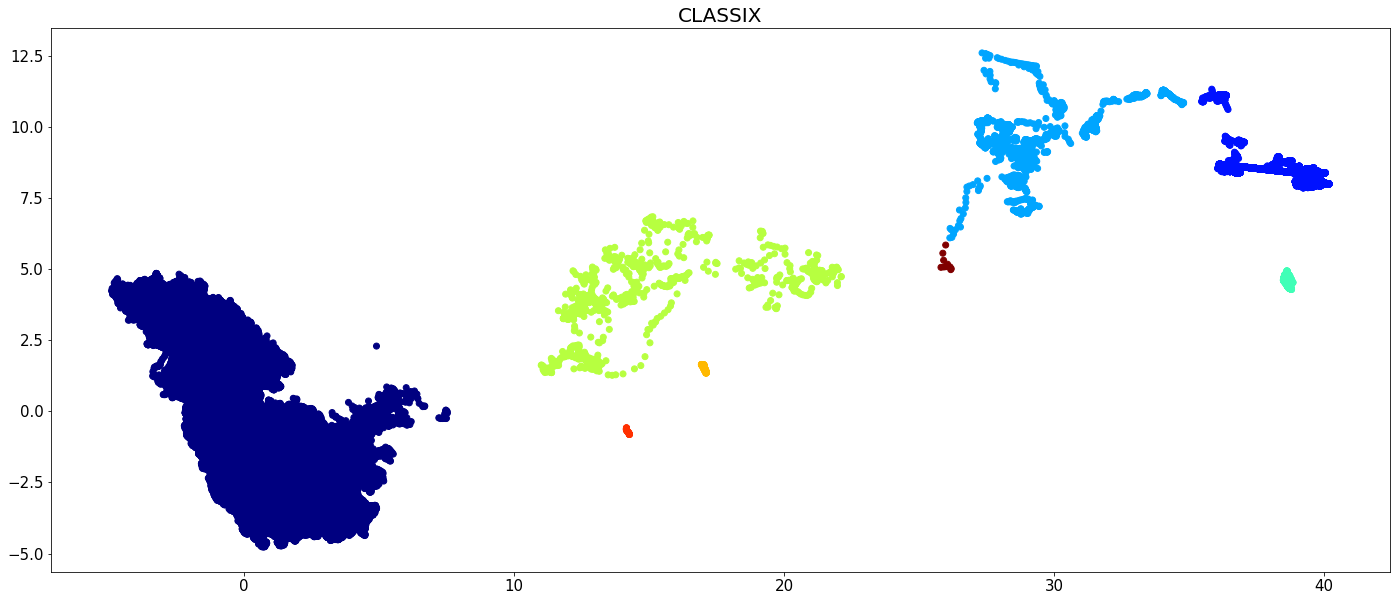

In [8]:
sum_time = 0
for i in range(sample_size):
    st = time.time()
    clx = CLASSIX(sorting='pca', radius=0.45, verbose=0, group_merging='distance')
    clx.fit_transform(data)
    et = time.time()
    sum_time = sum_time + et - st

timing.append(sum_time/sample_size)
print("Average consume time: ", sum_time/sample_size)
plt.figure(figsize=(24,10))
plt.scatter(data[:,0], data[:,1], c=clx.labels_, cmap='jet')
plt.tick_params(axis='both',  labelsize=15)
plt.title('CLASSIX',  fontsize=20)
plt.show()

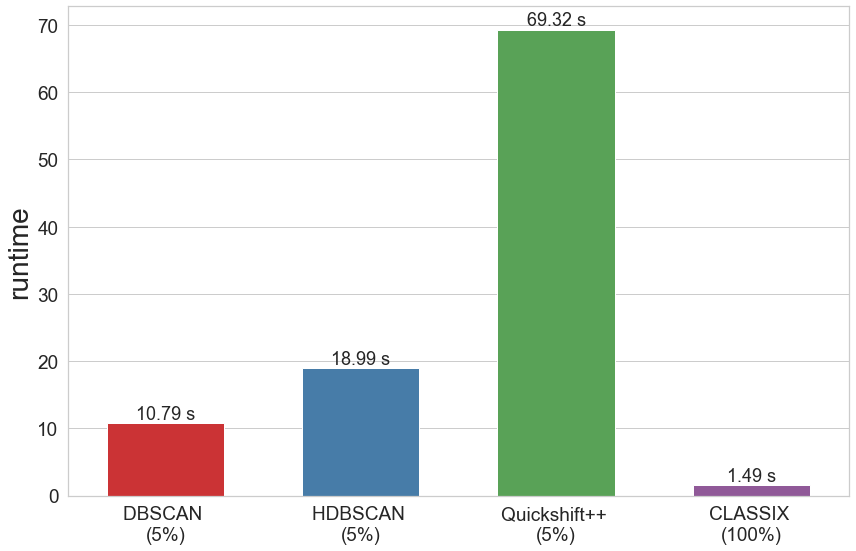

In [9]:
bardf = pd.DataFrame()
names = ['DBSCAN \n(5%)', 'HDBSCAN \n(5%)', 'Quickshift++ \n(5%)', 'CLASSIX \n(100%)']
bardf['clustering'] = names
bardf['runtime'] = timing

def colors_from_values(values, palettes):
    norm = (values - min(values)) / (max(values) - min(values))
    indices = np.round(norm * (len(values) - 1)).astype(np.int32)
    palettes = sns.color_palette(palettes, len(values))
    return np.array(palettes).take(indices, axis=0)


pvals = np.array([0.1,0.2,0.4,0.6]) # np.array(timing)/np.sum(timing)
plt.figure(figsize=(14, 9))
sns.set(font_scale=1.5, style="whitegrid")
ax = sns.barplot(x="clustering", y="runtime", data=bardf, width=0.6, 
                 palette=colors_from_values(pvals, 'Set1'))

ax.bar_label(ax.containers[0], fmt='%.2f s')
ax.set(xlabel=None)
ax.set_ylabel("runtime", fontsize=28)
plt.tick_params(axis='both', labelsize=19)
plt.show()